In [83]:
import os
import numpy as np
import pandas as pd
import pickle 
from utils import *

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cross_decomposition import PLSRegression
import statsmodels.api as sm
from sklearn.linear_model import Ridge, GammaRegressor, PoissonRegressor
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima
import datetime

pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings("ignore")

# Initial set up
### Load data

In [117]:
dev = pd.read_csv('Machine Learning Coding Challenge_dataset - consumption.csv', index_col=0)
print(dev.shape)
dev.head()

(87552, 11)


,Time,Sum [kWh].0,Sum [kWh].1,Sum [kWh].2,Sum [kWh].3,Sum [kWh].4,Sum [kWh].5,Sum [kWh].6,Sum [kWh].7,Sum [kWh].8,Sum [kWh].9
Electricity.Timestep,,,,,,,,,,,
0,01/01/2022 0:00,0.041346,0.066354,0.072797,0.002957,0.040572,0.044009,0.056274,0.003023,0.074690,0.103507
15,01/01/2022 0:15,0.024794,0.067132,0.091674,0.003018,0.009139,0.046210,0.040607,0.003114,0.056418,0.088745
30,01/01/2022 0:30,0.043701,0.066478,0.081484,0.002890,0.009055,0.023968,0.040729,0.002963,0.051122,0.087435
45,01/01/2022 0:45,0.043374,0.076322,0.074713,0.002990,0.009225,0.044659,0.022517,0.003052,0.051604,0.068454
60,01/01/2022 1:00,0.023892,0.066500,0.074037,0.002914,0.009189,0.026412,0.019049,0.003063,0.050926,0.017362


In [118]:
# Convert to datetime
dev['Time'] = pd.to_datetime(dev['Time'])
dev

,Time,Sum [kWh].0,Sum [kWh].1,Sum [kWh].2,Sum [kWh].3,Sum [kWh].4,Sum [kWh].5,Sum [kWh].6,Sum [kWh].7,Sum [kWh].8,Sum [kWh].9
Electricity.Timestep,,,,,,,,,,,
0,2022-01-01 00:00:00,0.041346,0.066354,0.072797,0.002957,0.040572,0.044009,0.056274,0.003023,0.074690,0.103507
15,2022-01-01 00:15:00,0.024794,0.067132,0.091674,0.003018,0.009139,0.046210,0.040607,0.003114,0.056418,0.088745
30,2022-01-01 00:30:00,0.043701,0.066478,0.081484,0.002890,0.009055,0.023968,0.040729,0.002963,0.051122,0.087435
45,2022-01-01 00:45:00,0.043374,0.076322,0.074713,0.002990,0.009225,0.044659,0.022517,0.003052,0.051604,0.068454
60,2022-01-01 01:00:00,0.023892,0.066500,0.074037,0.002914,0.009189,0.026412,0.019049,0.003063,0.050926,0.017362
...,...,...,...,...,...,...,...,...,...,...,...
1313205,2024-06-30 22:45:00,0.030725,0.511905,0.221242,0.002995,0.041006,0.046388,0.031654,0.003056,0.044872,0.017680
1313220,2024-06-30 23:00:00,0.037726,0.075644,0.081569,0.003052,0.041401,0.070488,0.031202,0.002831,0.043478,0.029522
1313235,2024-06-30 23:15:00,0.030268,0.076506,0.093647,0.003052,0.025955,0.052038,0.031095,0.002972,0.049309,0.038980


# Extra features

### Suspected 3 seasonalities

In [119]:
dev['month'] = dev['Time'].dt.month
dev['day_of_week'] = dev['Time'].dt.day_of_week
dev['hour_of_day'] = dev['Time'].dt.hour
dev

,Time,Sum [kWh].0,Sum [kWh].1,Sum [kWh].2,Sum [kWh].3,Sum [kWh].4,Sum [kWh].5,Sum [kWh].6,Sum [kWh].7,Sum [kWh].8,Sum [kWh].9,month,day_of_week,hour_of_day
Electricity.Timestep,,,,,,,,,,,,,,
0,2022-01-01 00:00:00,0.041346,0.066354,0.072797,0.002957,0.040572,0.044009,0.056274,0.003023,0.074690,0.103507,1,5,0
15,2022-01-01 00:15:00,0.024794,0.067132,0.091674,0.003018,0.009139,0.046210,0.040607,0.003114,0.056418,0.088745,1,5,0
30,2022-01-01 00:30:00,0.043701,0.066478,0.081484,0.002890,0.009055,0.023968,0.040729,0.002963,0.051122,0.087435,1,5,0
45,2022-01-01 00:45:00,0.043374,0.076322,0.074713,0.002990,0.009225,0.044659,0.022517,0.003052,0.051604,0.068454,1,5,0
60,2022-01-01 01:00:00,0.023892,0.066500,0.074037,0.002914,0.009189,0.026412,0.019049,0.003063,0.050926,0.017362,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313205,2024-06-30 22:45:00,0.030725,0.511905,0.221242,0.002995,0.041006,0.046388,0.031654,0.003056,0.044872,0.017680,6,6,22
1313220,2024-06-30 23:00:00,0.037726,0.075644,0.081569,0.003052,0.041401,0.070488,0.031202,0.002831,0.043478,0.029522,6,6,23
1313235,2024-06-30 23:15:00,0.030268,0.076506,0.093647,0.003052,0.025955,0.052038,0.031095,0.002972,0.049309,0.038980,6,6,23


In [120]:
households = [i for i in dev.columns if i.startswith("Sum")]

# Exploration

In [6]:
# total NANs 
dev.isna().sum()

Time           0
Sum [kWh].0    0
Sum [kWh].1    0
Sum [kWh].2    0
Sum [kWh].3    0
Sum [kWh].4    0
Sum [kWh].5    0
Sum [kWh].6    0
Sum [kWh].7    0
Sum [kWh].8    0
Sum [kWh].9    0
month          0
day_of_week    0
hour_of_day    0
dtype: int64

In [7]:
# Min and Max
dev.min(), dev.max()

(Time           2022-01-01 00:00:00
 Sum [kWh].0               0.022584
 Sum [kWh].1               0.010881
 Sum [kWh].2               0.008427
 Sum [kWh].3                    0.0
 Sum [kWh].4               0.008301
 Sum [kWh].5               0.017967
 Sum [kWh].6               0.012244
 Sum [kWh].7                    0.0
 Sum [kWh].8               0.019283
 Sum [kWh].9               0.016848
 month                            1
 day_of_week                      0
 hour_of_day                      0
 dtype: object,
 Time           2024-06-30 23:45:00
 Sum [kWh].0               1.525849
 Sum [kWh].1               1.556929
 Sum [kWh].2               1.436898
 Sum [kWh].3               0.053291
 Sum [kWh].4               1.178009
 Sum [kWh].5               1.545542
 Sum [kWh].6               1.568173
 Sum [kWh].7               0.180356
 Sum [kWh].8                1.16733
 Sum [kWh].9               1.227204
 month                           12
 day_of_week                      6
 hour_of_day

In [8]:
# total NANs 
dev.isna().sum()

Time           0
Sum [kWh].0    0
Sum [kWh].1    0
Sum [kWh].2    0
Sum [kWh].3    0
Sum [kWh].4    0
Sum [kWh].5    0
Sum [kWh].6    0
Sum [kWh].7    0
Sum [kWh].8    0
Sum [kWh].9    0
month          0
day_of_week    0
hour_of_day    0
dtype: int64

# Seasonality and Trend

### Trend

The almost linear increase in the cumulative sum of the power consumption of all households indicates there there is little trend in the data
- trend would be visible here as convex or concave functions
- no trend means the time series are somewhat stationary except for possible seanonalities (to be explored next)
- no detrending in the following for modelling

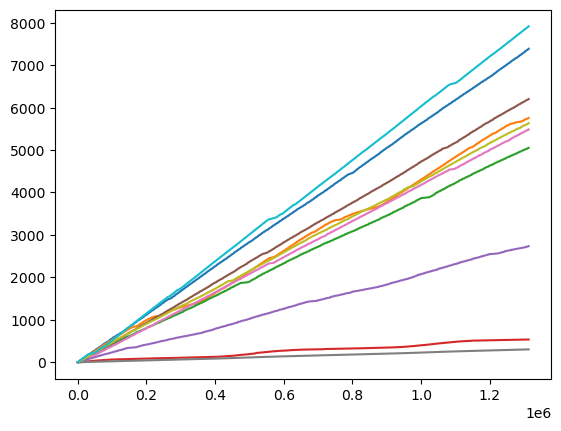

In [9]:
for i in households:
    plt.plot(dev[i].cumsum())

### Seasonality

Seasonl pattern is strongest in household 1, 3, 4 and 7. Other households are somewhat constant over the year with household 9 having a drop in the first two months of the year.

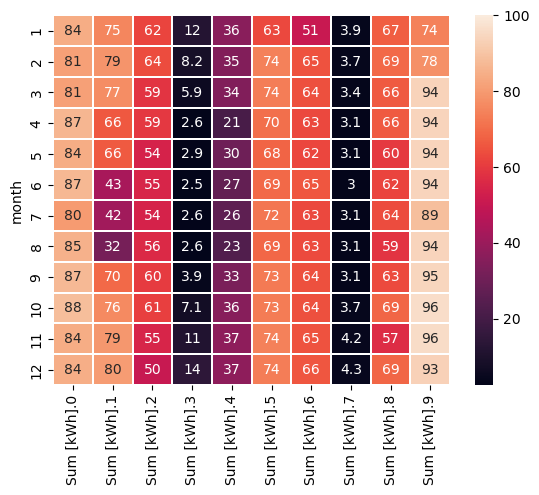

In [10]:
# Average monthly consumption in Wh
svm = sns.heatmap(dev.groupby(['month']).mean()[households] * 1000,
                  linewidths=0.1,
                  vmax=100, 
                  linecolor='white', 
                  annot=True)

Different usage patterns: some households (e.g. household 0) are much more active on weekends, some have little dependence on the day of week, or even slighly less consumption on Sat and Sun.

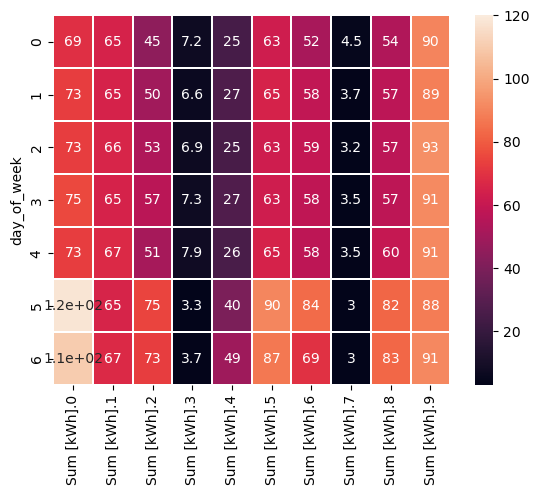

In [11]:
# Average day of the week consumption in Wh
svm = sns.heatmap(dev.groupby(['day_of_week']).mean()[households] * 1000,
                  linewidths=0.1,
                  vmax=120, 
                  linecolor='white', 
                  annot=True)

Daily rhythms in all households visible: consumption is increased over lunchtime and thereafter until evening (at least in UTC time)
- households 3 and 7 with little consumption are back to normal after 18 pm
- households 0, 5, 6, 9, show that energy consumption peters out after 20 pm
- households 2 and 8 show a similar pattern with nightly activity until well into the wee morning hours (in UTC time, maybe different time zone?)

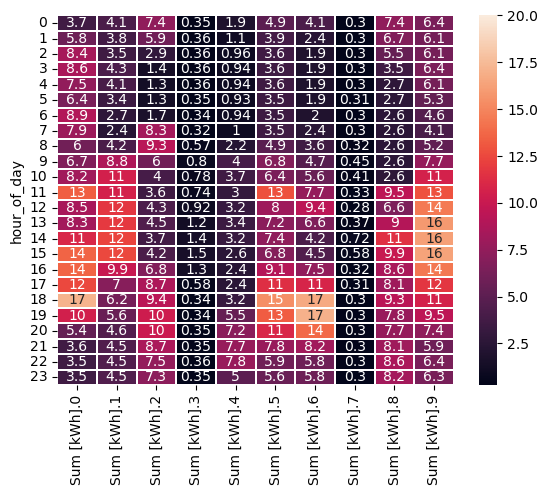

In [12]:
# Average monthly consumption in 100 Wh
svm = sns.heatmap(dev.groupby(['hour_of_day']).mean()[households] * 100,
                  linewidths=0.1,
                  vmax=20, 
                  linecolor='white', 
                  annot=True)

Conclusion: households show different usage patters that are only sometimes correlated. Some housholds may be in a different time zone altogether. It is likely that the usage of one household does not depend on the usage of another household at that same time. Whether a model for all households at the same time makes sense needs to be further investigated.

# Correlations

Most households seem not to be too correlated at lag 0, sometimes even negatively correlated. This indicates a different location or at least a different usage pattern?

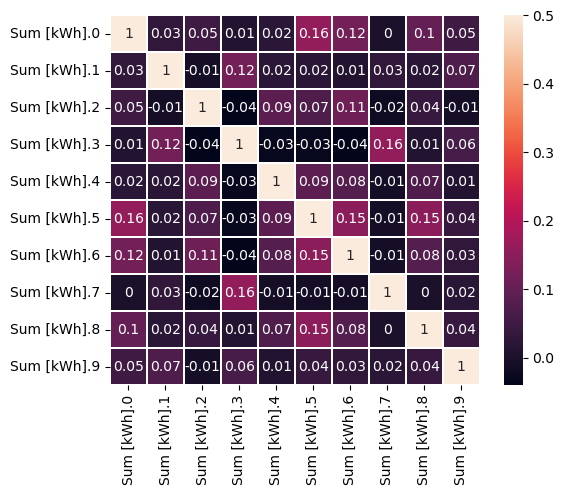

In [13]:
svm = sns.heatmap(dev[households].corr().round(2), 
                  linewidths=0.1,
                  vmax=0.5, 
                  square=True, 
                  linecolor='white', 
                  annot=True)

Pairplot reveals the correaltion structure as well: almost no correlation for many households, in fact, households seem to be sometimes active while others are not (as can be seen in the weird "L" pattern here)

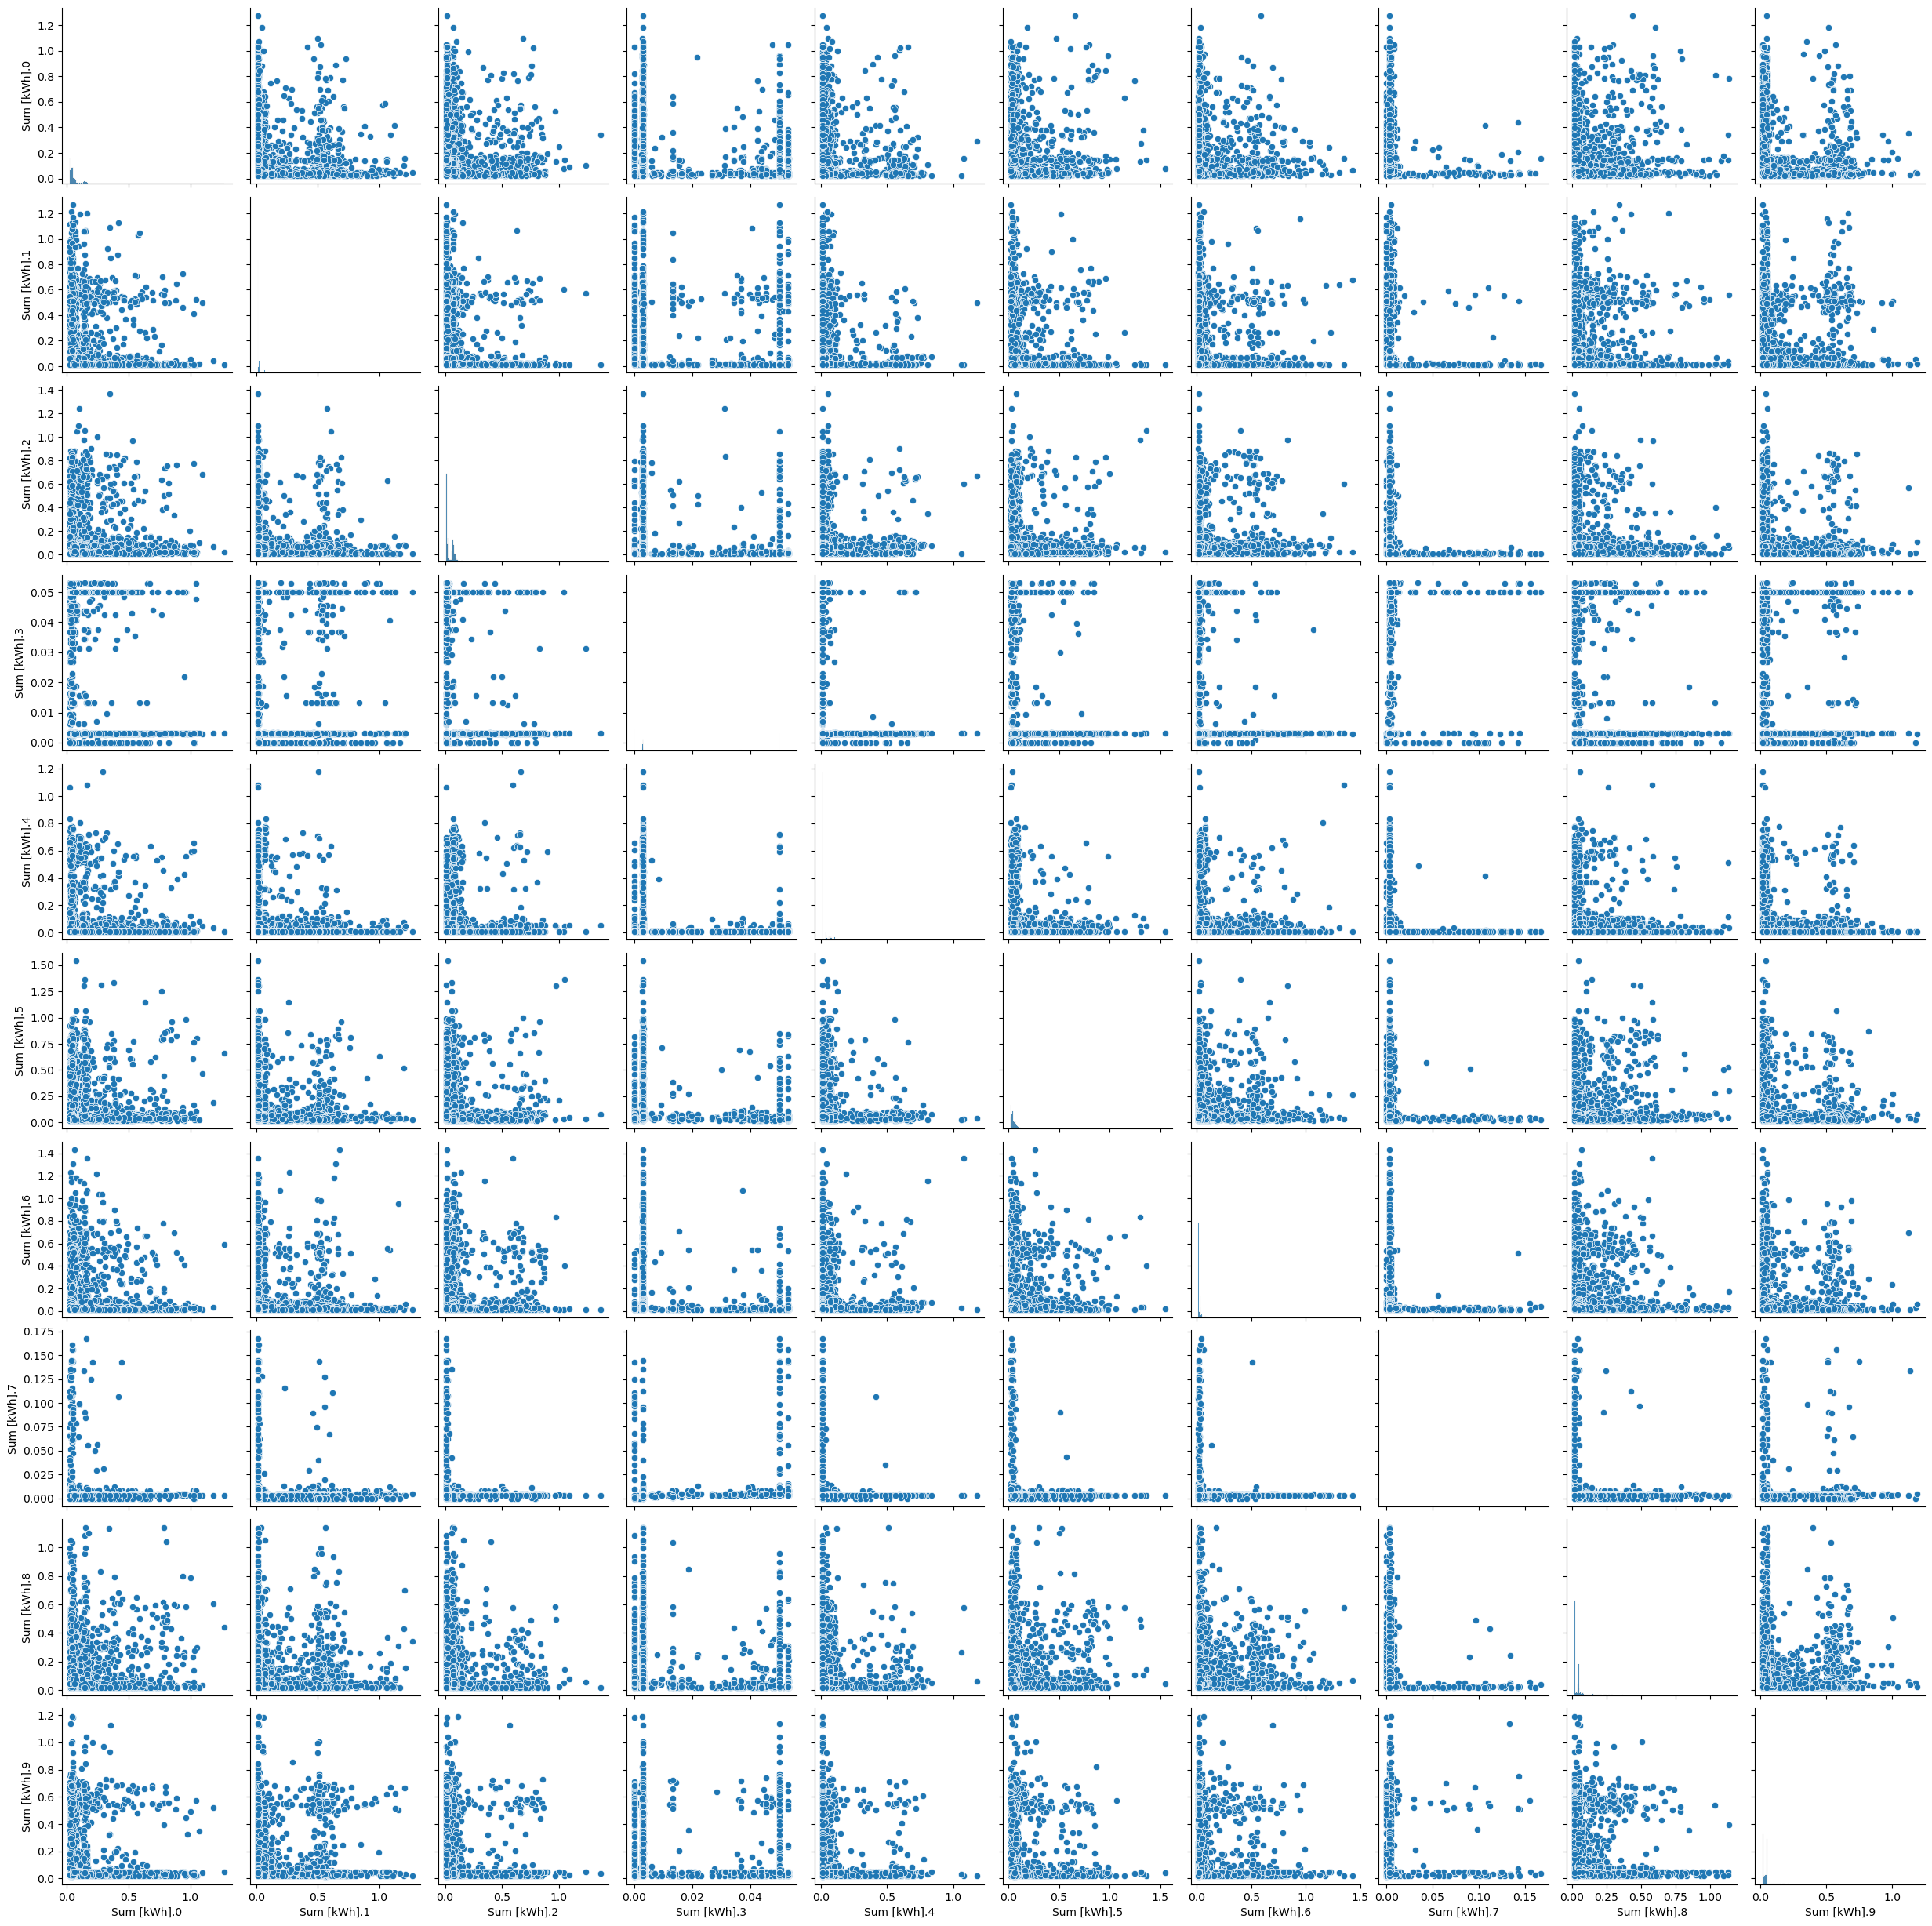

In [14]:
sns.pairplot(dev[households][0:10000])

### Autocorrealtion

The autocorrealtion structure clearly identifies a daily rhythm in most households, although some have multi-day rhythms (1 and 9).

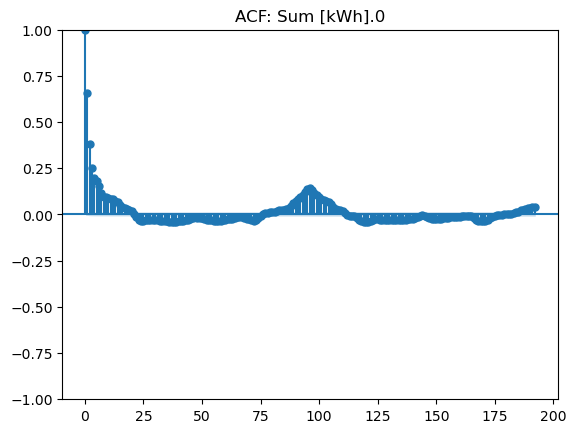

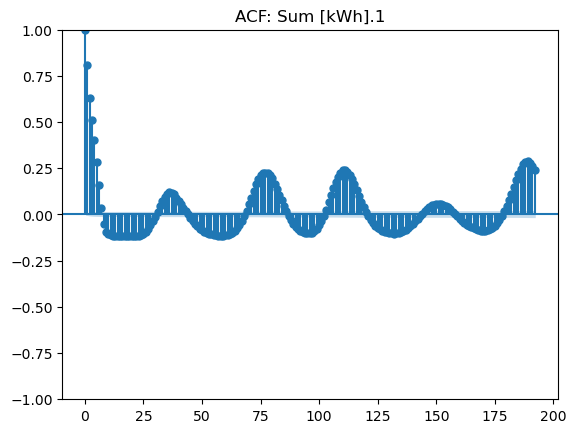

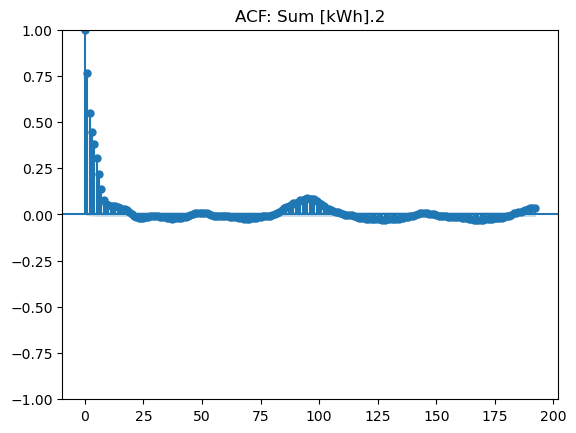

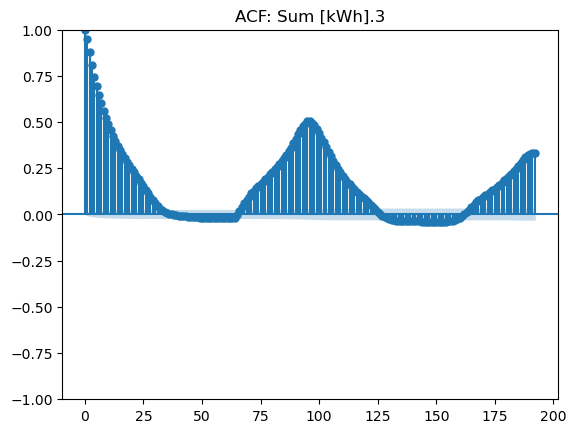

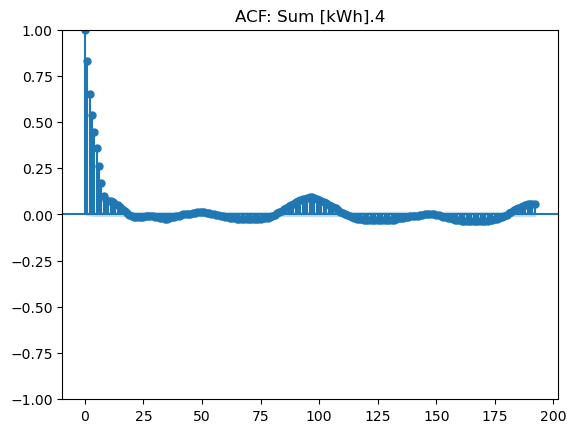

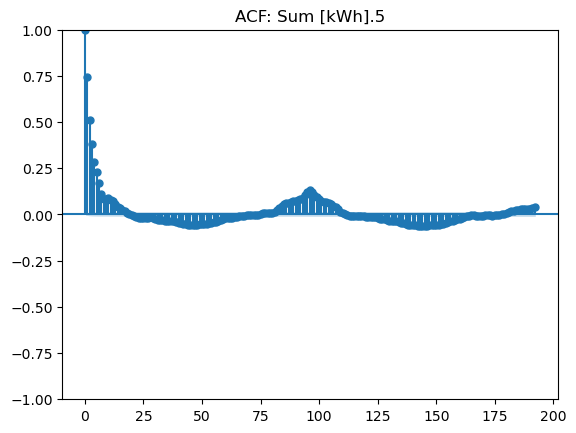

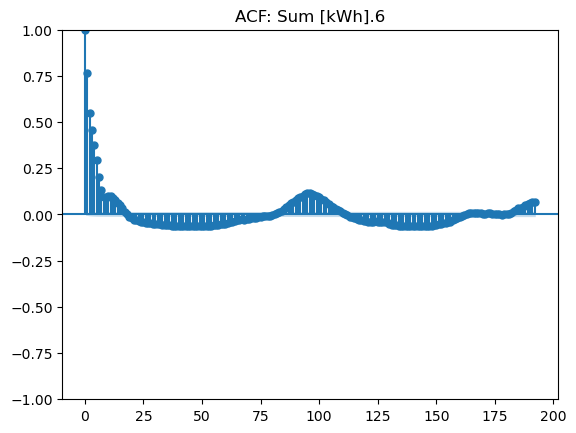

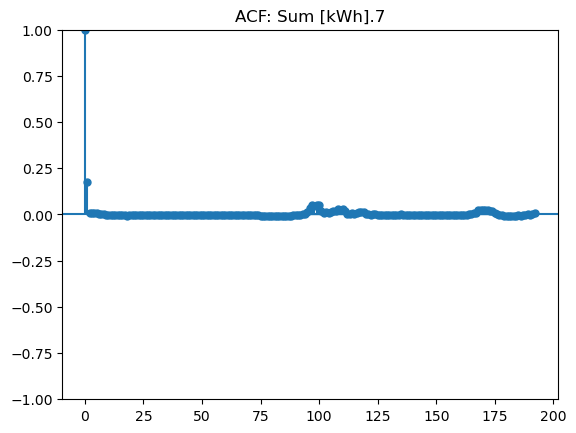

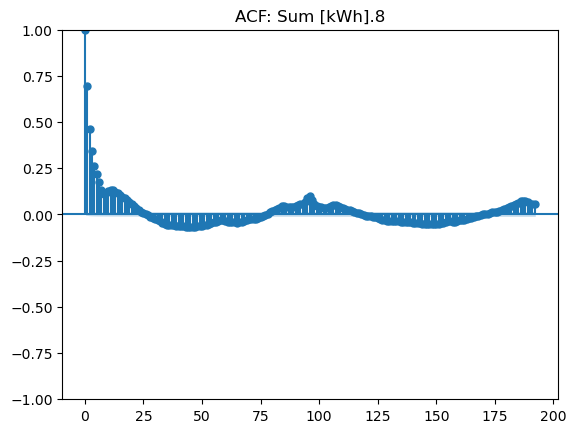

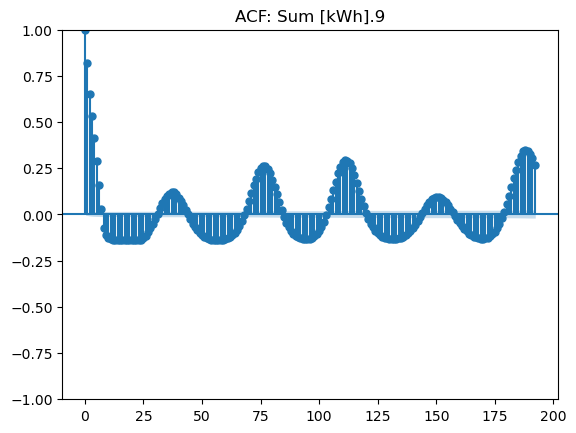

In [15]:
points_per_day = 24*60/15
for i in households:
    sm.graphics.tsa.plot_acf(dev[i].values.squeeze(),
                             lags=2*points_per_day ,
                              title = f"ACF: {i}")
    plt.show()

### Partial Autocorrelation

Most households seem to be well described in terms of a few consumption lags (0-25). 
- More information is only added when taking in full 24 hour lagged consumption for all but households 1 and 9
- households 1 and 9 have a sub-24 hour rhythm. What could this be? Here, It is probably necessary to model with the respective long-range lags, up to 200 or even more


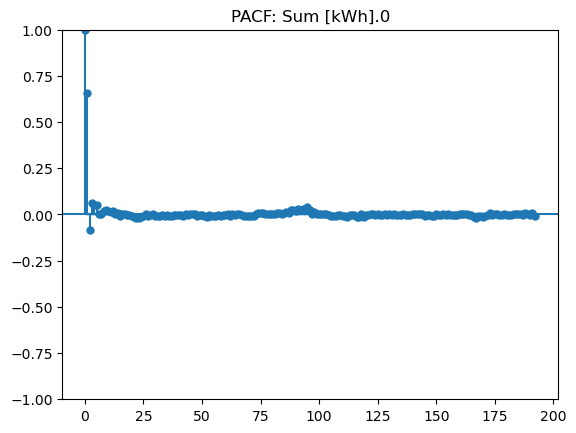

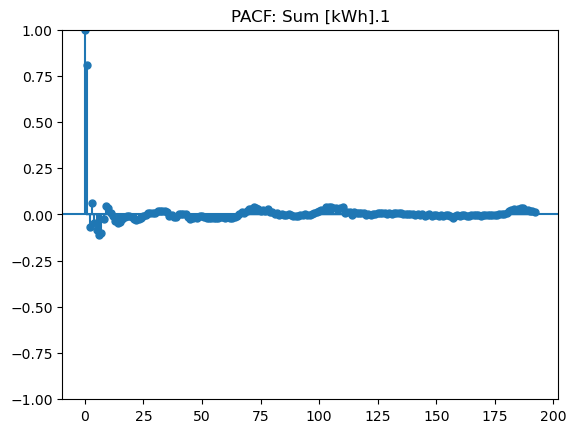

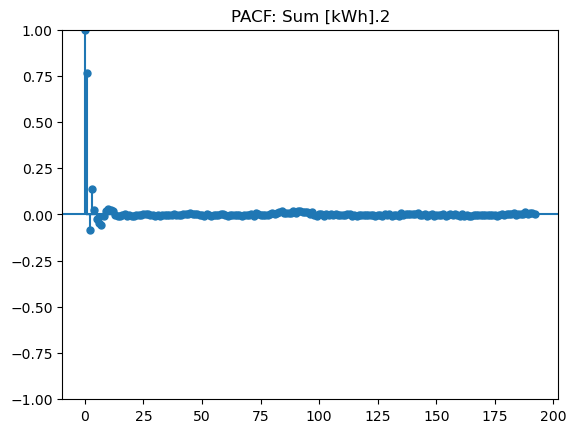

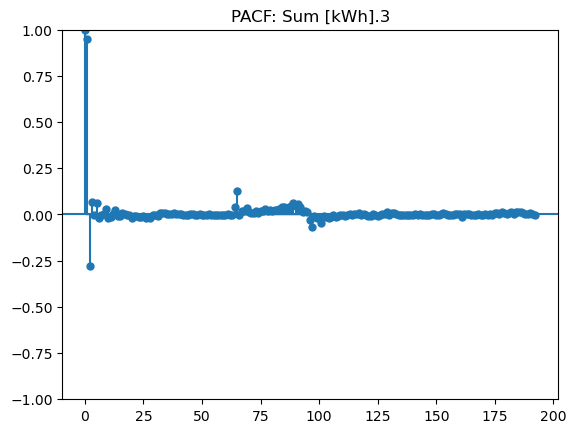

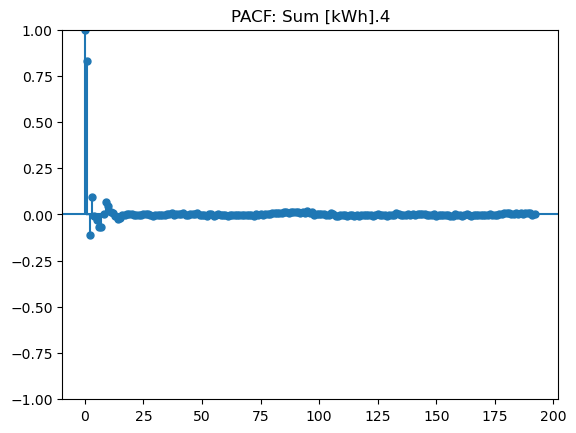

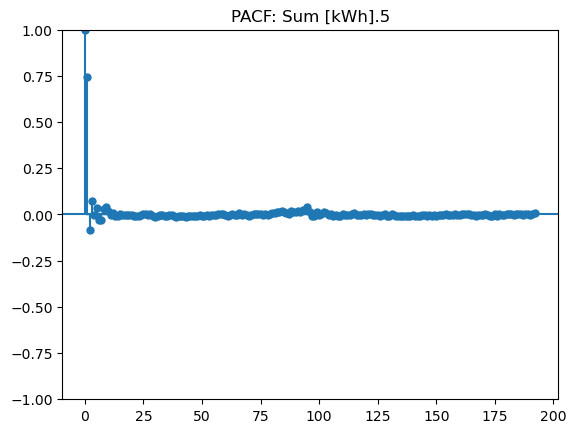

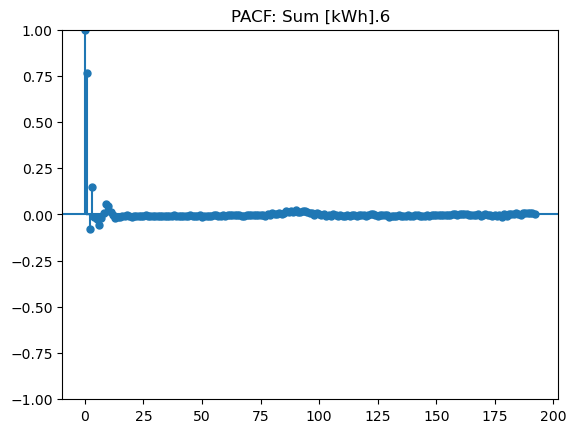

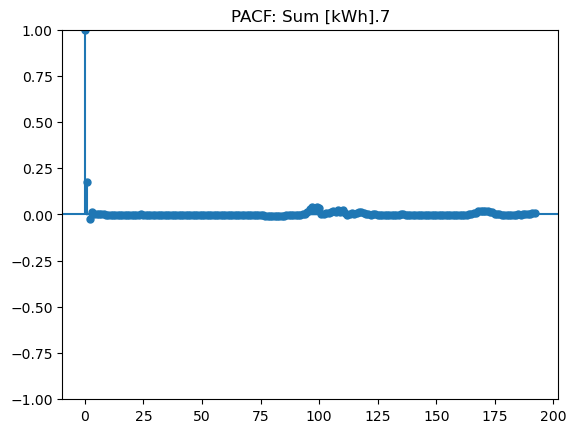

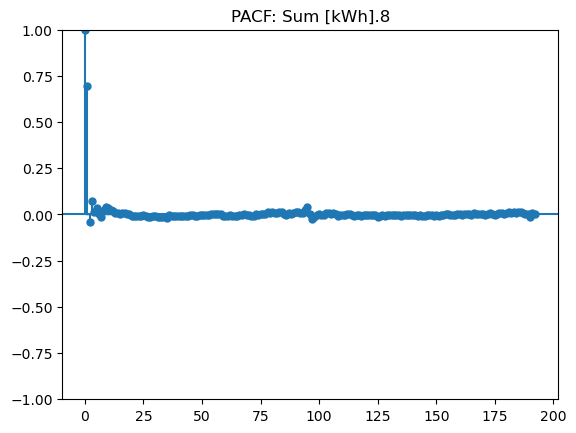

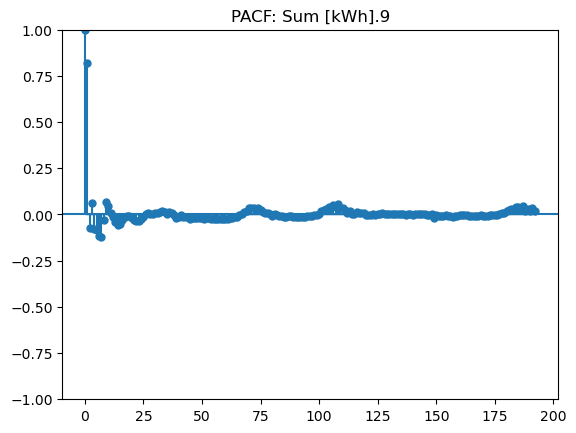

In [17]:
points_per_day = 24*60/15
for i in households:
    sm.graphics.tsa.plot_pacf(dev[i].values.squeeze(), 
                              lags=2*points_per_day ,
                              title = f"PACF: {i}")
    plt.show()

### Cross-correlation

In [18]:
import matplotlib.mlab as mlab

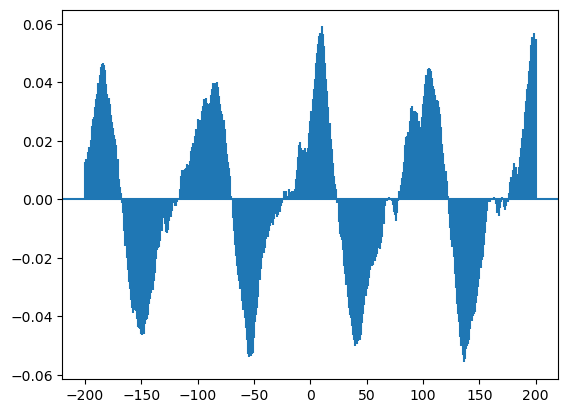

In [19]:
plt.xcorr(dev[households[0]], 
          dev[households[1]], 
          maxlags=200, 
          normed=True, 
          detrend=mlab.detrend_mean
          );

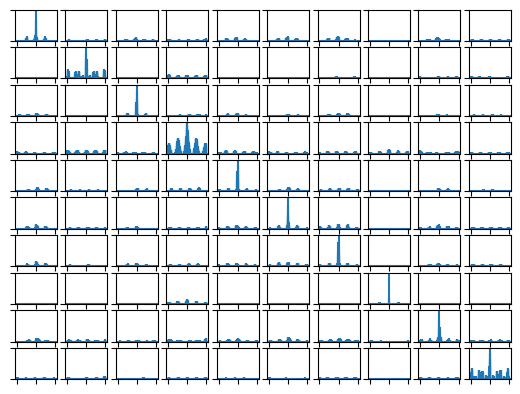

In [ ]:
fig, axs = plt.subplots(10, 10)
for i in range(0, len(households)):
    for j in range(0, len(households)):
        axs[i, j].xcorr(dev[households[i]], 
                        dev[households[j]], 
                        maxlags=200, 
                        normed=True, 
                        detrend=mlab.detrend_mean);
        axs[i, j].set_ylim([0, 1])
        axs[i, j].set_yticklabels([])
        axs[i, j].set_xticklabels([])

Conclusion: although the different households experience little

# Model preparation

### Distribution assumption

The data is physically restricted to positive values, and hence skewed, which violates the assumptions of a linear regression. It might make sense to build models with a different distribution assumption, like a Gamma distribution. 
- As a quick workaround, one could model transformed variables cast to approximately normal distribution (like a Box-Cox transformation) 
- A sklearn Quantile transformer could map the skewed distribution according to quantiles to a normal distribution

I could not make either transformation work in sklearn as I think thereis a bug in the inverse transformation from normal back to the original space. I had weird issues with NaNs in the residuals that I could not explain. More time would be needed to run a model on properly scaled and transformed variables.

Another point is the bi-modality of the distribution. This would warrant further exploration at this point. I am skipping this investigtion due to time contraints.

<Axes: xlabel='Sum [kWh].0', ylabel='Density'>

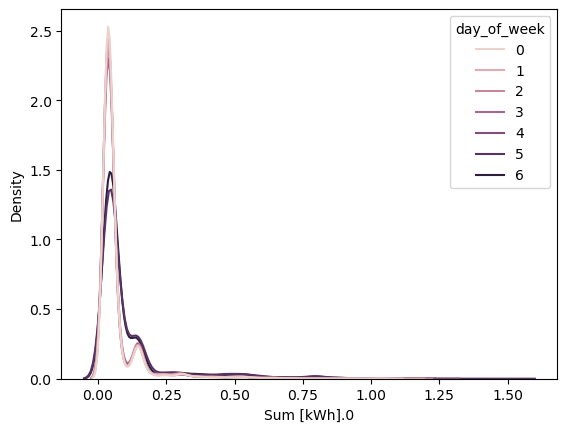

In [121]:
sns.kdeplot(data=dev, x=households[0], hue="day_of_week")

### Get fourier features for the 3 main seasonalities

In [122]:
dev = dev.set_index('Time', drop=True)
dev

,Sum [kWh].0,Sum [kWh].1,Sum [kWh].2,Sum [kWh].3,Sum [kWh].4,Sum [kWh].5,Sum [kWh].6,Sum [kWh].7,Sum [kWh].8,Sum [kWh].9,month,day_of_week,hour_of_day
Time,,,,,,,,,,,,,
2022-01-01 00:00:00,0.041346,0.066354,0.072797,0.002957,0.040572,0.044009,0.056274,0.003023,0.074690,0.103507,1,5,0
2022-01-01 00:15:00,0.024794,0.067132,0.091674,0.003018,0.009139,0.046210,0.040607,0.003114,0.056418,0.088745,1,5,0
2022-01-01 00:30:00,0.043701,0.066478,0.081484,0.002890,0.009055,0.023968,0.040729,0.002963,0.051122,0.087435,1,5,0
2022-01-01 00:45:00,0.043374,0.076322,0.074713,0.002990,0.009225,0.044659,0.022517,0.003052,0.051604,0.068454,1,5,0
2022-01-01 01:00:00,0.023892,0.066500,0.074037,0.002914,0.009189,0.026412,0.019049,0.003063,0.050926,0.017362,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 22:45:00,0.030725,0.511905,0.221242,0.002995,0.041006,0.046388,0.031654,0.003056,0.044872,0.017680,6,6,22
2024-06-30 23:00:00,0.037726,0.075644,0.081569,0.003052,0.041401,0.070488,0.031202,0.002831,0.043478,0.029522,6,6,23
2024-06-30 23:15:00,0.030268,0.076506,0.093647,0.003052,0.025955,0.052038,0.031095,0.002972,0.049309,0.038980,6,6,23


In [123]:
# Prepare the indices for TEST as well
for i in range(0, int(24*60/15)):
    last_date = dev.iloc[[-1]].index
    last_date = last_date + datetime.timedelta(minutes=15)
    dev = pd.concat([dev, pd.DataFrame(index=[last_date[0]])], axis=0)
dev

,Sum [kWh].0,Sum [kWh].1,Sum [kWh].2,Sum [kWh].3,Sum [kWh].4,Sum [kWh].5,Sum [kWh].6,Sum [kWh].7,Sum [kWh].8,Sum [kWh].9,month,day_of_week,hour_of_day
2022-01-01 00:00:00,0.041346,0.066354,0.072797,0.002957,0.040572,0.044009,0.056274,0.003023,0.074690,0.103507,1.0,5.0,0.0
2022-01-01 00:15:00,0.024794,0.067132,0.091674,0.003018,0.009139,0.046210,0.040607,0.003114,0.056418,0.088745,1.0,5.0,0.0
2022-01-01 00:30:00,0.043701,0.066478,0.081484,0.002890,0.009055,0.023968,0.040729,0.002963,0.051122,0.087435,1.0,5.0,0.0
2022-01-01 00:45:00,0.043374,0.076322,0.074713,0.002990,0.009225,0.044659,0.022517,0.003052,0.051604,0.068454,1.0,5.0,0.0
2022-01-01 01:00:00,0.023892,0.066500,0.074037,0.002914,0.009189,0.026412,0.019049,0.003063,0.050926,0.017362,1.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01 22:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-01 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-01 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-01 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
points_per_day = 24*60/15
points_per_week = 7 * 24*60/15
points_per_year = 365.25 * 24*60/15

In [125]:
# Features for intra-day rhythms
four_terms1 = FourierFeaturizer(points_per_day, 1)
_, exogD = four_terms1.fit_transform(dev[households[0]])

# Features for intra-week rhythms
four_terms2 = FourierFeaturizer(points_per_week, 1)
_, exogW = four_terms2.fit_transform(dev[households[0]])

# Features for intra-year rhythms
four_terms3 = FourierFeaturizer(points_per_year, 1)
_, exogY = four_terms3.fit_transform(dev[households[0]])

In [126]:
exog = pd.concat([exogD, exogW, exogY], axis=1)
exog

,FOURIER_S96-0,FOURIER_C96-0,FOURIER_S672-0,FOURIER_C672-0,FOURIER_S35064-0,FOURIER_C35064-0
0,0.065403,0.997859,0.009350,0.999956,0.000179,1.000000
1,0.130526,0.991445,0.018699,0.999825,0.000358,1.000000
2,0.195090,0.980785,0.028046,0.999607,0.000538,1.000000
3,0.258819,0.965926,0.037391,0.999301,0.000717,1.000000
4,0.321439,0.946930,0.046733,0.998907,0.000896,1.000000
...,...,...,...,...,...,...
87643,-0.258665,0.965967,0.467238,-0.884131,0.002867,-0.999996
87644,-0.194934,0.980816,0.458951,-0.888461,0.002687,-0.999996
87645,-0.130368,0.991466,0.450624,-0.892714,0.002508,-0.999997
87646,-0.065244,0.997869,0.442258,-0.896888,0.002329,-0.999997


# Train and Validation split

I create a validation data set that I use to test my predictions on. Ideally, one would want to create multiple backtesting data sets to tune hyperparameter (as I describe below) and also a hold-out test set which can be used to test the final model. Here, I use only a single validation to also decide on some general design choices.

In [127]:
# Data to be submitted
test = dev.iloc[-int(24*60/15):].copy()
test_exog = exog.iloc[-int(24*60/15):].copy()


In [ ]:
dev = dev.iloc[:-int(24*60/15)]
exog = exog.iloc[:-int(24*60/15)]

In [151]:
val = dev.iloc[-10000:].copy()
val_exog = exog.iloc[-10000:].copy()
val.shape, val_exog.shape

((10000, 13), (10000, 6))

In [129]:
train = dev.iloc[0:-10000].copy()
train_exog = exog.iloc[0:-10000]
train.shape, train_exog.shape

((77552, 13), (77552, 6))

# Model for seasonality

### Data prep

In [130]:
train = train[households]
train

,Sum [kWh].0,Sum [kWh].1,Sum [kWh].2,Sum [kWh].3,Sum [kWh].4,Sum [kWh].5,Sum [kWh].6,Sum [kWh].7,Sum [kWh].8,Sum [kWh].9
2022-01-01 00:00:00,0.041346,0.066354,0.072797,0.002957,0.040572,0.044009,0.056274,0.003023,0.074690,0.103507
2022-01-01 00:15:00,0.024794,0.067132,0.091674,0.003018,0.009139,0.046210,0.040607,0.003114,0.056418,0.088745
2022-01-01 00:30:00,0.043701,0.066478,0.081484,0.002890,0.009055,0.023968,0.040729,0.002963,0.051122,0.087435
2022-01-01 00:45:00,0.043374,0.076322,0.074713,0.002990,0.009225,0.044659,0.022517,0.003052,0.051604,0.068454
2022-01-01 01:00:00,0.023892,0.066500,0.074037,0.002914,0.009189,0.026412,0.019049,0.003063,0.050926,0.017362
...,...,...,...,...,...,...,...,...,...,...
2024-03-18 18:45:00,0.060216,0.012820,0.018482,0.003004,0.009055,0.096036,0.311851,0.003086,0.019802,0.045698
2024-03-18 19:00:00,0.049696,0.012881,0.017863,0.002998,0.009140,0.108450,0.094029,0.003080,0.019821,0.018409
2024-03-18 19:15:00,0.076115,0.038126,0.022268,0.002909,0.015450,0.064155,0.310313,0.003145,0.019764,0.017780
2024-03-18 19:30:00,0.055687,0.064806,0.042501,0.002990,0.043704,0.084922,0.428200,0.002997,0.019620,0.040795


### Linear regression

This part is to regress out the seasonalities in the data with a simple linear model. A Ridge linear regression will do the trick here.
- Since the features are only minimally correlated (if at all), we do only need a very small alpha to guarantee numerical stability. 
- The model with 6 features has no other relevant hyperparameter, hence we do not tune the model in cross-validation
- features are all on the same scale, and we model the different households individually (for now), so we do not need scaling or de-meaning of the features.

Run a linear regression on the transformed variables

In [131]:
# Train model
seasons_lm = Ridge(alpha=0.1)
seasons_lm.fit(train_exog, train)

Ridge(alpha=0.1)

In [132]:
seasons_pred = seasons_lm.predict(train_exog)
seasons_pred.min(), seasons_pred.max()

(-0.005985152966328985, 0.14721073148762506)

### Get residuals

In [133]:
# REsiduals
train_minus_season = pd.DataFrame(train - seasons_pred,
                                  columns=households)
train_minus_season

,Sum [kWh].0,Sum [kWh].1,Sum [kWh].2,Sum [kWh].3,Sum [kWh].4,Sum [kWh].5,Sum [kWh].6,Sum [kWh].7,Sum [kWh].8,Sum [kWh].9
2022-01-01 00:00:00,-0.033858,0.018521,-0.005650,-0.003339,-0.007861,-0.025107,-0.012771,0.000052,-0.001152,0.054665
2022-01-01 00:15:00,-0.049326,0.020607,0.014728,-0.003130,-0.038148,-0.020604,-0.025364,0.000160,-0.017220,0.042019
2022-01-01 00:30:00,-0.029448,0.021098,0.006066,-0.003130,-0.037067,-0.040602,-0.022192,0.000023,-0.020320,0.042660
2022-01-01 00:45:00,-0.028924,0.031919,0.000844,-0.002921,-0.035718,-0.017733,-0.037392,0.000122,-0.017661,0.025455
2022-01-01 01:00:00,-0.047677,0.022903,0.001731,-0.002910,-0.034568,-0.033881,-0.037898,0.000141,-0.016192,-0.024042
...,...,...,...,...,...,...,...,...,...,...
2024-03-18 18:45:00,-0.029635,-0.072302,-0.059780,-0.004464,-0.041478,-0.006533,0.210940,-0.000824,-0.080208,-0.064916
2024-03-18 19:00:00,-0.038033,-0.069571,-0.060437,-0.004172,-0.041388,0.007275,-0.005902,-0.000779,-0.079546,-0.089391
2024-03-18 19:15:00,-0.009443,-0.041610,-0.055967,-0.003960,-0.034990,-0.035485,0.211556,-0.000663,-0.078817,-0.087109
2024-03-18 19:30:00,-0.027657,-0.012177,-0.035562,-0.003574,-0.006565,-0.013051,0.330807,-0.000758,-0.078031,-0.061098


In [134]:
# Error on prediction
np.mean((train_minus_season.values)**2)/np.mean((train.values)**2)

0.7215132908185411

In [135]:
# Measure performance of this first model in the original untransformed space
from sklearn.metrics import mean_squared_error, r2_score
for i in range(0, len(households)):
    print(mean_squared_error(train.loc[:,households[i]], seasons_pred[:,i]))

0.013926273696287083
0.0209562678811695
0.012506068773546486
0.0001434173612186421
0.0057232102072268
0.012387053559445067
0.016557247624924897
6.555211318065757e-05
0.00833231991416261
0.02225814526932254


Check the distribution of residuals

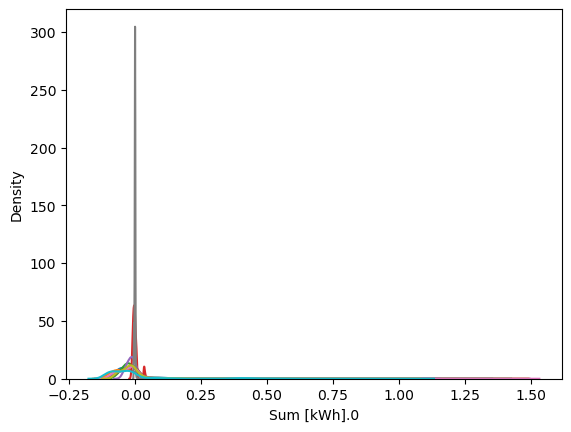

In [136]:
# Approximately normal: Check!
# Bi-modlaity is still an issue, would require further invetigations
for i in households:
    sns.kdeplot(data=train_minus_season, x=i)

# Exogenous features

The next modelling step could include exogenous features in addition to the lagged version of the power consumption. 
Possible exogenous features (apart from the above seasonal indicators):
- school holidays and public holidays
- time zones
- location
- climate
- size of the houshold (number people, number rooms, number of appliances)
- etc.

# Second autoregressive model

This final prediction model is supposed to predict the energy consumption 24 hours ahead. To this end, we:
- first regress out the seasonalities (DONE)
- use the residuals as input for a second model fit on these residuals (practically, boosting)
- use the lagged version of the time series using data that is more than 24 hours old (i.e., to be able to predict by over 24 hours)
- this is a direct forecaster trained on future 24 hour data , as opposed to a stepwise forecaster that makes one-step-at-a-time predictions and accumulates error over time

Since there is non-zero cross-correlation, I use a model that takes all 10 time series to predict all ten time series. Hence, I use a single model for a baseline prediction estimate. Single models for each times series individually might perform better since the cross-correlation is small and no further knowledge is available, how and why they should be related/correlated to each other. The above exogenous features might shed some light into this pattern.

In [137]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

The window length (number of lags) is a critical hyperparamter. In a real scenario, this parameter would need to be tuned. Here I use a ball-park estimate of the lags required to capture the patterns that I have seen in the ACF/PACF plots. 

In [138]:
# Window length, i.e., the number of lags to use for prediction
window_length = 48

As I mentioned above, the correct thing would be to run on the transformed residuals after making the original time series approximately normal. The below model, PLS, has an in-build centering and scaling natively from sklearn. Jowever, this does not remove the skewedness of the data. Outlier will affect the model fit!

In [139]:
# Get the 24 hour ahead block of data, then also account for the window length
output_y = train_minus_season[int(24*60/15):][window_length-1:]
output_y.shape

(77409, 10)

In [140]:
# Input is the original time series with lagged features
input_X = train[:-int(24*60/15)]
input_X = serve_data(input_X, window_length)
input_X.shape

(77409, 480)

### Partial least squares model

I use a Partial Least Squares model as the input features are correlated and potentially noise-corrupted. PArtial LEast squares handles this through a decomposition approach akin to PCA. The number of components is a critial hyperparameter and needs to be tuned in a real model pipeline.
I have manually tested the number of components but do not claim optimality.

In [141]:
pls2 = PLSRegression(n_components = 10)
pls2.fit(input_X, output_y)

PLSRegression(n_components=10)

In [142]:
pred2 = pls2.predict(input_X)
pred2.shape

(77409, 10)

In [143]:
# Measure performance of this second model on the residuals
from sklearn.metrics import mean_squared_error
for i in range(0, len(households)):
    print(mean_squared_error(train_minus_season.loc[:,households[i]][int(24*60/15)+window_length-1:], pred2[:,i]))

0.013572394743674242
0.019071246575883015
0.012313121512014217
0.00011904073381589703
0.005579346033915428
0.012172811142641755
0.016097238366820813
6.523741886504509e-05
0.008243825287187036
0.019280506494233414


# Validation

In [158]:
val = val[households]

### Predictions from exogenous feature model

In [159]:
seasons_pred = seasons_lm.predict(val_exog)
seasons_pred.shape

(10000, 10)

### Predictions from the autoregressive model

In [160]:
input_val = serve_data(val[households], window_length)
input_val.shape

(9953, 480)

In [161]:
pred2 = pls2.predict(input_val)
pred2.shape

(9953, 10)

Add the predictions of the two models in the next step. I have noticed that the PLS regression does not decrease the model error by much. This could have multiple reasons:
- PLS not tuned properly (hyperparameter are just a guess)
- a single model for each time series might be more appropriate unless we know how these households are interrelated
- Distribution assumptions are violated hence we get a badly scaled model
- Overfitting in other ways
- Nonlinear model required

In [162]:
val_predictions = pd.DataFrame(seasons_pred, columns=households).copy()
val_predictions.iloc[int(24*60/15)+window_length-1:] += pred2[:-(int(24*60/15))]
val_predictions

,Sum [kWh].0,Sum [kWh].1,Sum [kWh].2,Sum [kWh].3,Sum [kWh].4,Sum [kWh].5,Sum [kWh].6,Sum [kWh].7,Sum [kWh].8,Sum [kWh].9
0,0.078826,0.071418,0.077408,0.005954,0.049685,0.094260,0.094123,0.003653,0.095380,0.095698
1,0.076539,0.068629,0.076926,0.005651,0.049272,0.092230,0.092229,0.003602,0.094048,0.092525
2,0.074245,0.065852,0.076342,0.005350,0.048780,0.090096,0.090172,0.003552,0.092590,0.089321
3,0.071954,0.063098,0.075660,0.005055,0.048212,0.087865,0.087961,0.003503,0.091014,0.086098
4,0.069675,0.060380,0.074881,0.004765,0.047569,0.085548,0.085605,0.003456,0.089325,0.082871
...,...,...,...,...,...,...,...,...,...,...
9995,0.060340,0.040751,0.063336,0.000979,0.047085,0.068466,0.061785,0.003064,0.084125,0.065648
9996,0.061206,0.042886,0.061483,0.000972,0.045523,0.068406,0.060980,0.003099,0.083513,0.055676
9997,0.059365,0.041856,0.062361,0.000406,0.045354,0.068003,0.060856,0.003027,0.081636,0.045038
9998,0.054761,0.038509,0.065494,-0.000738,0.046031,0.066243,0.060224,0.002834,0.077968,0.033885


In [163]:
# Error on prediction
np.mean((val.values- val_predictions.values)**2)/np.mean((val.values)**2)

0.6846045526103239

# Test prediction

First, predict the baseline kWh with the seasonality model

In [165]:
# Seasonal model
test_season_pred = seasons_lm.predict(test_exog)
test_season_pred.shape

(96, 10)

Now get the data from the end of the validation time frame, i.e., the data with which we now predict 24 hours ahead

In [169]:
# Make prediction with the last time steps from the validation data to predict test
input_test = serve_data(val[households].iloc[-window_length-int(24*60/15)+1:], window_length)
input_test.shape

(96, 480)

Make the AR prediction with model 2.

In [171]:
pred_ar = pls2.predict(input_test)
pred_ar.shape

(96, 10)

Add the predictions together and save.

In [174]:
test_pred = pd.DataFrame(test_season_pred+pred_ar, columns=households, index=test.index)
test_pred.to_csv('test_predictions.csv')

# Deployment

For deployment, we could use MLflow or similiar
- Dockerise the model including all preprocessors
- Deploy the model on a Sagemaker or Mlflow endpoint
- Make predictions with the model for each new time step, predicting 24 hours ahead
- Monitor, after 24 hours, the performance of the model according to a predefined standard (e.g., mean squared error)
- define a threshold below which the model needs to be retrained
- using all new data, retrain a model (incl. new hyperparameter search) and dockersise as well
- monitor the new model in a A/B test like environment and make sure the model actually outperforms the old one
- switch models (new one in production, old one still as a backup) and monitor their performances
- in case the new model starts to degrade or have any issues, swap back to the old model
- repeat the monitoring and retraining continuously